## TWC Forecast Run Query (Production PAIRS) - multiple ensemble members

In [1]:
from ibmpairs import paw
import pandas as pd
import calendar
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import geopandas as gpd

This notebook requires1 a `ibmpairspass.txt` file.  The content of this file has to contain your PAIRS username and API password in the following format: `pairs.res.ibm.com:<USRNAME>:<PASSWORD>`

In [2]:
from ibmpairs import paw, authentication
with open("../ibmpairspass.txt") as my_file:
    PAIRS_API_KEY=my_file.readline().replace('\n', '')
PAIRS_USER = "deborah.mcglynn@ibm.com" # REPLACE WITH YOUR USERNAME
PAIRS_SERVER = "https://pairs.res.ibm.com/"
OAUTH = authentication.OAuth2(api_key = PAIRS_API_KEY)

In [3]:
# dictionary of TWC variables and associated PAIRS layer IDs
var_id_dict = {'PRECIP':50686, 'TMIN':50683, 'TMAX':50684, 'TAVG':50685}

In [4]:
def query_point(var_id, lat_lon, forecasts, horizon, start_time, end_time):
    """
    A wrapper function for making point-queries to the TWC dataset (ID 466) with the PAIRS API.
    
    var_id     : The ID of the data layer that will be queried.
    lat, lon   : Latitude and longitude coordinates for the point of interest.
    forecasts   : Values of the `forecast` dimension which refers to the prototype numbers (between 1 and 50) 
                 as well as `mean` and `std` for the prototypes' mean and standard deviation. Format for the 
                 individual prototype numbers must be zero-padded, e.g. `01`, `05` or `25`. 
    horizon    : The daily horizon value for a forecast run
    start_time : The start timestamp used to filter matches for all of the above parameters.
    end_time   : Similar to `start_time`, but for the end timestamp.
    
    Note:  When extracting entire forecast runs, care must be taken to select appropriate start and end timestamps
           for each horizon value.  These can be calculated for each horizon using the forecast start date and 
           the forecast horizon.
    """
    layers = []
    for forecast in forecasts:
        layer = {
            "type" : "raster", "id" : var_id,
             "temporal" : {"intervals" : [{"start" : str(start_time), "end" : str(end_time)}]},
             "dimensions" : [
                {"name" : "forecast", "value" : str(forecast)}, {"name" : "horizon", "value" : str(horizon)}
              ]
            }
        layers = layers + [layer]
        

    query_json = {
        "layers" : layers,
        "spatial" : {
            "type" : "point",
            "coordinates" : lat_lon
        },
        
        # This is the default time-range (to be used if a time-range isn't given in the above block/s.)
        # It is required, even though the information might not be used.
        "temporal" : {
            "intervals" : [
                {"snapshot" : "1982-01-01"}
            ]
        },
        "outputType" : "json"}

    # query data
    query = paw.PAIRSQuery(query_json, PAIRS_SERVER,  auth=OAUTH, authType='api-key')
    #query = paw.PAIRSQuery(query_json, PAIRS_SERVER, PAIRS_CREDENTIALS)
    query.submit()
    if len(query.vdf) == 0:
        return None
    else:
        return query.vdf


In [5]:
# ========== Set these values ==========

# Short name of the variable that will be queried (can be: TMIN, TMAX, TAVG or PRECIP)
var1 = "TAVG"
var2 = "PRECIP"

# Latitude and longitude coordinates of the point-of-interest
# Single lat/lon point, or list of lat/lont points
#query_lat, query_lon = [40.8], [-112.0]
#query_lat, query_lon = [40.8, 50.1, 30.3], [-112.0, -60.2, -10.3]
#query_lat, query_lon = [43.185145], [3.001593] # Narbonne
#query_lat, query_lon = [19.7331], [72.9135] # India
query_lat, query_lon = [-1.286389], [36.817222] # Nairobi
lat_lon = [vals for pair in zip(query_lat, query_lon) for vals in pair]

# Values for the forecast dimension (can be between "01" and "50", as well as "mean" or "std")
#forecasts = ["01", "02"]
forecasts = [str(x).zfill(2) for x in range(1, 51)]

# Start year and month of the forecast run
forecast_start_year = 2021
forecast_start_month = 1

# Number of months in a forecast run
num_forecast_months = 6

In [6]:
# Calculate the number of horizon days in the forecast run
start_date = datetime(forecast_start_year, forecast_start_month, 1).date()
forecast_run_dates = [start_date+relativedelta(months=x) for x in np.arange(num_forecast_months)]
forecast_month_days = [calendar.monthrange(x.year, x.month)[1] for x in forecast_run_dates]
total_forecast_days = np.sum(forecast_month_days)
print(f"Total forecast days: {total_forecast_days}")

Total forecast days: 181


In [7]:
#PAIRS_SERVER      = 'https://pairs.res.ibm.com/'
values = np.full([0,len(query_lat)], None)
timestamps = []
forecast_horizons = []

df_precip = pd.DataFrame()

for fh in tqdm(np.arange(0, total_forecast_days), desc="Querying PAIRS"):
    start_datetime = (start_date + timedelta(days=int(fh-1))).strftime("%Y-%m-%dT23:59:59Z") # subtract 1 to get end of previous day
    end_datetime = (start_date + timedelta(days=int(fh))).strftime("%Y-%m-%dT23:59:59Z") # end of current day
    query_df = query_point(var_id=var_id_dict[var2],
                           lat_lon=lat_lon,
                           forecasts=forecasts,
                           horizon=fh,
                           start_time=start_datetime,
                           end_time=end_datetime)

    #assert len(query_df) == 1, f"Expected only one record but {len(query_df)} records were returned"
    if isinstance(query_df, gpd.geodataframe.GeoDataFrame):
 #       values = np.vstack( [values, query_df['value'].values] )
        df_precip = pd.concat([df_precip, query_df], axis=0)
 #   elif query_df == None:
 #       values = np.vstack( [values, np.array([np.nan]*values.shape[1])]  )
 #   else:
 #       pass
    
#    timestamps.append(datetime.strptime(end_datetime[0:-10], "%Y-%m-%d").date())    
#    forecast_horizons.append(fh)
    

#values = values.astype(np.float)

Querying PAIRS: 100%|████████████████████████████████████████████████████████████████| 181/181 [05:16<00:00,  1.75s/it]


## Convert timestamp to datetime because paw isn't working

In [8]:
df_precip['timestamp'] =  pd.to_datetime(df_precip['timestamp'], unit='ms', origin = 'unix')
df_precip.head()

layerId  timestamp  longitude  latitude     value  region  \
0    50686 2021-01-01  36.817222 -1.286389  0.950271     NaN   
1    50686 2021-01-01  36.817222 -1.286389  0.974493     NaN   
2    50686 2021-01-01  36.817222 -1.286389  5.348533     NaN   
3    50686 2021-01-01  36.817222 -1.286389  1.046889     NaN   
4    50686 2021-01-01  36.817222 -1.286389  0.396216     NaN   

                property                   geometry  
0  forecast:01;horizon:0  POINT (36.81722 -1.28639)  
1  forecast:02;horizon:0  POINT (36.81722 -1.28639)  
2  forecast:03;horizon:0  POINT (36.81722 -1.28639)  
3  forecast:04;horizon:0  POINT (36.81722 -1.28639)  
4  forecast:05;horizon:0  POINT (36.81722 -1.28639)

## Extract forecast (ensemble member) and horizon

In [9]:
df_precip["forecast"] = df_precip['property'].str.split(";", n = 1, expand = True)[0]
df_precip["horizon"] = df_precip['property'].str.split(";", n = 1, expand = True)[1]
df_precip["forecast"] = df_precip["forecast"].str.split("forecast:").str[1]
df_precip["horizon"] = df_precip["horizon"].str.split("horizon:").str[1]
df_precip

layerId  timestamp  longitude  latitude     value  region  \
0     50686 2021-01-01  36.817222 -1.286389  0.950271     NaN   
1     50686 2021-01-01  36.817222 -1.286389  0.974493     NaN   
2     50686 2021-01-01  36.817222 -1.286389  5.348533     NaN   
3     50686 2021-01-01  36.817222 -1.286389  1.046889     NaN   
4     50686 2021-01-01  36.817222 -1.286389  0.396216     NaN   
..      ...        ...        ...       ...       ...     ...   
45    50686 2021-06-30  36.817222 -1.286389  1.639769     NaN   
46    50686 2021-06-30  36.817222 -1.286389  0.535110     NaN   
47    50686 2021-06-30  36.817222 -1.286389  0.000000     NaN   
48    50686 2021-06-30  36.817222 -1.286389  0.000000     NaN   
49    50686 2021-06-30  36.817222 -1.286389  0.137292     NaN   

                   property                   geometry forecast horizon  
0     forecast:01;horizon:0  POINT (36.81722 -1.28639)       01       0  
1     forecast:02;horizon:0  POINT (36.81722 -1.28639)       02       0  
2     forecast:03;horizon:0  POINT (36.81722 -1.28639)       03       0  
3     forecast:04;horizon:0  POINT (36.81722 -1.28639)       04       0  
4     forecast:05;horizon:0  POINT (36.81722 -1.28639)       05       0  
..                      ...                        ...      ...     ...  
45  forecast:46;horizon:180  POINT (36.81722 -1.28639)       46     180  
46  forecast:47;horizon:180  POINT (36.81722 -1.28639)       47     180  
47  forecast:48;horizon:180  POINT (36.81722 -1.28639)       48     180  
48  forecast:49;horizon:180  POINT (36.81722 -1.28639)       49     180  
49  forecast:50;horizon:180  POINT (36.81722 -1.28639)       50     180  

[9050 rows x 10 columns]

In [10]:
df_precip['value'] = df_precip['value'].astype('float')

In [11]:
df_precip['forecast'].unique()

array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22',
       '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33',
       '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44',
       '45', '46', '47', '48', '49', '50'], dtype=object)

In [13]:
#PAIRS_SERVER      = 'https://pairs.res.ibm.com/'
values = np.full([0,len(query_lat)], None)
timestamps = []
forecast_horizons = []

df_temp = pd.DataFrame()

for fh in tqdm(np.arange(0, total_forecast_days), desc="Querying PAIRS"):
    start_datetime = (start_date + timedelta(days=int(fh-1))).strftime("%Y-%m-%dT23:59:59Z") # subtract 1 to get end of previous day
    end_datetime = (start_date + timedelta(days=int(fh))).strftime("%Y-%m-%dT23:59:59Z") # end of current day
    query_df = query_point(var_id=var_id_dict[var1],
                           lat_lon=lat_lon,
                           forecasts=forecasts,
                           horizon=fh,
                           start_time=start_datetime,
                           end_time=end_datetime)

    #assert len(query_df) == 1, f"Expected only one record but {len(query_df)} records were returned"
    if isinstance(query_df, gpd.geodataframe.GeoDataFrame):
 #       values = np.vstack( [values, query_df['value'].values] )
        df_temp = pd.concat([df_temp, query_df], axis=0)
 #   elif query_df == None:
 #       values = np.vstack( [values, np.array([np.nan]*values.shape[1])]  )
 #   else:
 #       pass
    
#    timestamps.append(datetime.strptime(end_datetime[0:-10], "%Y-%m-%d").date())    
#    forecast_horizons.append(fh)
    

#values = values.astype(np.float)

Querying PAIRS: 100%|████████████████████████████████████████████████████████████████| 181/181 [05:16<00:00,  1.75s/it]


In [14]:
df_temp['timestamp'] =  pd.to_datetime(df_temp['timestamp'], unit='ms', origin = 'unix')
df_temp.head()

layerId  timestamp  longitude  latitude       value  region  \
0    50685 2021-01-01  36.817222 -1.286389  290.645355     NaN   
1    50685 2021-01-01  36.817222 -1.286389  290.270996     NaN   
2    50685 2021-01-01  36.817222 -1.286389  289.214386     NaN   
3    50685 2021-01-01  36.817222 -1.286389  291.047089     NaN   
4    50685 2021-01-01  36.817222 -1.286389  287.569000     NaN   

                property                   geometry  
0  forecast:01;horizon:0  POINT (36.81722 -1.28639)  
1  forecast:02;horizon:0  POINT (36.81722 -1.28639)  
2  forecast:03;horizon:0  POINT (36.81722 -1.28639)  
3  forecast:04;horizon:0  POINT (36.81722 -1.28639)  
4  forecast:05;horizon:0  POINT (36.81722 -1.28639)

In [15]:
df_temp["forecast"] = df_temp['property'].str.split(";", n = 1, expand = True)[0]
df_temp["horizon"] = df_temp['property'].str.split(";", n = 1, expand = True)[1]
df_temp["forecast"] = df_temp["forecast"].str.split("forecast:").str[1]
df_temp["horizon"] = df_temp["horizon"].str.split("horizon:").str[1]
df_temp

layerId  timestamp  longitude  latitude       value  region  \
0     50685 2021-01-01  36.817222 -1.286389  290.645355     NaN   
1     50685 2021-01-01  36.817222 -1.286389  290.270996     NaN   
2     50685 2021-01-01  36.817222 -1.286389  289.214386     NaN   
3     50685 2021-01-01  36.817222 -1.286389  291.047089     NaN   
4     50685 2021-01-01  36.817222 -1.286389  287.569000     NaN   
..      ...        ...        ...       ...         ...     ...   
45    50685 2021-06-30  36.817222 -1.286389  290.611816     NaN   
46    50685 2021-06-30  36.817222 -1.286389  289.834015     NaN   
47    50685 2021-06-30  36.817222 -1.286389  288.345581     NaN   
48    50685 2021-06-30  36.817222 -1.286389  292.339111     NaN   
49    50685 2021-06-30  36.817222 -1.286389  290.405212     NaN   

                   property                   geometry forecast horizon  
0     forecast:01;horizon:0  POINT (36.81722 -1.28639)       01       0  
1     forecast:02;horizon:0  POINT (36.81722 -1.28639)       02       0  
2     forecast:03;horizon:0  POINT (36.81722 -1.28639)       03       0  
3     forecast:04;horizon:0  POINT (36.81722 -1.28639)       04       0  
4     forecast:05;horizon:0  POINT (36.81722 -1.28639)       05       0  
..                      ...                        ...      ...     ...  
45  forecast:46;horizon:180  POINT (36.81722 -1.28639)       46     180  
46  forecast:47;horizon:180  POINT (36.81722 -1.28639)       47     180  
47  forecast:48;horizon:180  POINT (36.81722 -1.28639)       48     180  
48  forecast:49;horizon:180  POINT (36.81722 -1.28639)       49     180  
49  forecast:50;horizon:180  POINT (36.81722 -1.28639)       50     180  

[9050 rows x 10 columns]

In [16]:
df_temp['value'] = df_temp['value'].astype('float')

In [17]:
df_temp['forecast'].unique()

array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22',
       '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33',
       '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44',
       '45', '46', '47', '48', '49', '50'], dtype=object)

In [32]:
df_values = df_precip.merge(df_temp, how = 'inner', on = ['timestamp', 'longitude', 'latitude', 'region','property','geometry', 'forecast', 'horizon'])
df_values

layerId_x  timestamp  longitude  latitude   value_x  region  \
0         50686 2021-01-01  36.817222 -1.286389  0.950271     NaN   
1         50686 2021-01-01  36.817222 -1.286389  0.974493     NaN   
2         50686 2021-01-01  36.817222 -1.286389  5.348533     NaN   
3         50686 2021-01-01  36.817222 -1.286389  1.046889     NaN   
4         50686 2021-01-01  36.817222 -1.286389  0.396216     NaN   
...         ...        ...        ...       ...       ...     ...   
9045      50686 2021-06-30  36.817222 -1.286389  1.639769     NaN   
9046      50686 2021-06-30  36.817222 -1.286389  0.535110     NaN   
9047      50686 2021-06-30  36.817222 -1.286389  0.000000     NaN   
9048      50686 2021-06-30  36.817222 -1.286389  0.000000     NaN   
9049      50686 2021-06-30  36.817222 -1.286389  0.137292     NaN   

                     property                   geometry forecast horizon  \
0       forecast:01;horizon:0  POINT (36.81722 -1.28639)       01       0   
1       forecast:02;horizon:0  POINT (36.81722 -1.28639)       02       0   
2       forecast:03;horizon:0  POINT (36.81722 -1.28639)       03       0   
3       forecast:04;horizon:0  POINT (36.81722 -1.28639)       04       0   
4       forecast:05;horizon:0  POINT (36.81722 -1.28639)       05       0   
...                       ...                        ...      ...     ...   
9045  forecast:46;horizon:180  POINT (36.81722 -1.28639)       46     180   
9046  forecast:47;horizon:180  POINT (36.81722 -1.28639)       47     180   
9047  forecast:48;horizon:180  POINT (36.81722 -1.28639)       48     180   
9048  forecast:49;horizon:180  POINT (36.81722 -1.28639)       49     180   
9049  forecast:50;horizon:180  POINT (36.81722 -1.28639)       50     180   

      layerId_y     value_y  
0         50685  290.645355  
1         50685  290.270996  
2         50685  289.214386  
3         50685  291.047089  
4         50685  287.569000  
...         ...         ...  
9045      50685  290.611816  
9046      50685  289.834015  
9047      50685  288.345581  
9048      50685  292.339111  
9049      50685  290.405212  

[9050 rows x 12 columns]

In [33]:
df_values = df_values.rename(columns={"layerId_x":"Precip_layer", "layerId_y":"Temp_layer"})
df_values

Precip_layer  timestamp  longitude  latitude   value_x  region  \
0            50686 2021-01-01  36.817222 -1.286389  0.950271     NaN   
1            50686 2021-01-01  36.817222 -1.286389  0.974493     NaN   
2            50686 2021-01-01  36.817222 -1.286389  5.348533     NaN   
3            50686 2021-01-01  36.817222 -1.286389  1.046889     NaN   
4            50686 2021-01-01  36.817222 -1.286389  0.396216     NaN   
...            ...        ...        ...       ...       ...     ...   
9045         50686 2021-06-30  36.817222 -1.286389  1.639769     NaN   
9046         50686 2021-06-30  36.817222 -1.286389  0.535110     NaN   
9047         50686 2021-06-30  36.817222 -1.286389  0.000000     NaN   
9048         50686 2021-06-30  36.817222 -1.286389  0.000000     NaN   
9049         50686 2021-06-30  36.817222 -1.286389  0.137292     NaN   

                     property                   geometry forecast horizon  \
0       forecast:01;horizon:0  POINT (36.81722 -1.28639)       01       0   
1       forecast:02;horizon:0  POINT (36.81722 -1.28639)       02       0   
2       forecast:03;horizon:0  POINT (36.81722 -1.28639)       03       0   
3       forecast:04;horizon:0  POINT (36.81722 -1.28639)       04       0   
4       forecast:05;horizon:0  POINT (36.81722 -1.28639)       05       0   
...                       ...                        ...      ...     ...   
9045  forecast:46;horizon:180  POINT (36.81722 -1.28639)       46     180   
9046  forecast:47;horizon:180  POINT (36.81722 -1.28639)       47     180   
9047  forecast:48;horizon:180  POINT (36.81722 -1.28639)       48     180   
9048  forecast:49;horizon:180  POINT (36.81722 -1.28639)       49     180   
9049  forecast:50;horizon:180  POINT (36.81722 -1.28639)       50     180   

      Temp_layer     value_y  
0          50685  290.645355  
1          50685  290.270996  
2          50685  289.214386  
3          50685  291.047089  
4          50685  287.569000  
...          ...         ...  
9045       50685  290.611816  
9046       50685  289.834015  
9047       50685  288.345581  
9048       50685  292.339111  
9049       50685  290.405212  

[9050 rows x 12 columns]

## Plot forecast run time-series 

In [34]:
# set the number of ensemble members to include in the plot
ens_show = 50


# convert dates to python datetime object and convert Kelvin to Celcius where necessary
#plot_dates = [pd.to_datetime(x).date() for x in timestamps]
if var1 in ['TMIN', 'TMAX', 'TAVG']:
    df_values["value_y"] = df_values["value_y"] - 273.15

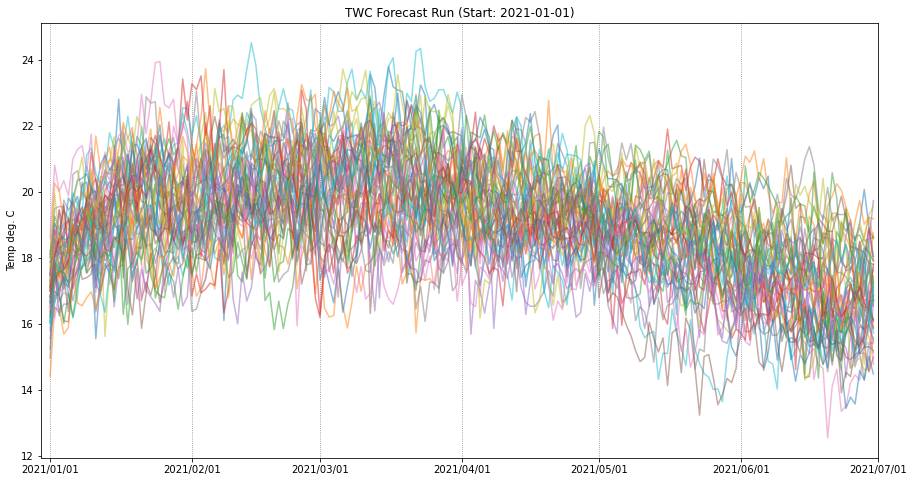

In [259]:
formatter = mdates.DateFormatter("%Y/%m/%d")
locator = mdates.MonthLocator()

fig = plt.figure(1, figsize=(15,8))

ax = plt.gca()
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)

#ax.plot(plot_dates, values, linestyle=None, marker='+', ms=8, mew=2)
for ens in df_values['forecast'].unique()[0:ens_show]:
    df_plot = df_values[df_values['forecast']==ens]
    ax.plot(df_plot['timestamp'].values, df_plot['value_y'].values, linestyle=None, marker='None', ms=8, mew=2, alpha = 0.5)

ax.set_xlim(start_date+timedelta(days=int(-2)), start_date+timedelta(days=int(181)))
plt.grid(axis='x', ls=":", color='0.5')
plt.ylabel('Temp deg. C')
plt.xlabel("")
plt.title(f"TWC Forecast Run (Start: {start_date.strftime('%Y-%m-%d')})")
plt.savefig("temp_50_ens_Jan-June_2021.png")
plt.show()

## Plot accumulation (for rainfall)

In [37]:
df_values['value_acc'] = np.nan
df_values.sort_values('timestamp', inplace=True)
for ens in df_values['forecast'].unique():
    df_values.loc[df_values['forecast']==ens, 'value_acc'] = \
                df_values.loc[df_values['forecast']==ens, 'value_x'].cumsum()

In [41]:
df_values.head()

Precip_layer  timestamp  longitude  latitude    value_x  region  \
0          50686 2021-01-01  36.817222 -1.286389   0.950271     NaN   
27         50686 2021-01-01  36.817222 -1.286389   2.199426     NaN   
28         50686 2021-01-01  36.817222 -1.286389   5.343882     NaN   
29         50686 2021-01-01  36.817222 -1.286389  10.278681     NaN   
30         50686 2021-01-01  36.817222 -1.286389   1.970090     NaN   

                 property                   geometry forecast horizon  \
0   forecast:01;horizon:0  POINT (36.81722 -1.28639)       01       0   
27  forecast:28;horizon:0  POINT (36.81722 -1.28639)       28       0   
28  forecast:29;horizon:0  POINT (36.81722 -1.28639)       29       0   
29  forecast:30;horizon:0  POINT (36.81722 -1.28639)       30       0   
30  forecast:31;horizon:0  POINT (36.81722 -1.28639)       31       0   

    Temp_layer    value_y  value_acc  
0        50685  17.495355   0.950271  
27       50685  17.460168   2.199426  
28       50685  16.036554   5.343882  
29       50685  16.364038  10.278681  
30       50685  16.667963   1.970090

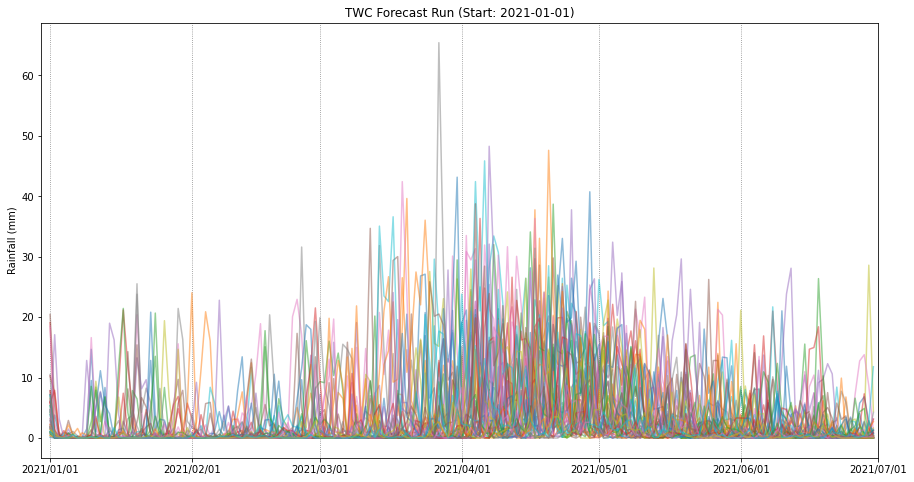

In [258]:
ens_show = 50


# convert dates to python datetime object and convert Kelvin to Celcius where necessary
#plot_dates = [pd.to_datetime(x).date() for x in timestamps]
if var2 in ['PRECIP']:
    df_values["value_x"] = df_values["value_x"]

formatter = mdates.DateFormatter("%Y/%m/%d")
locator = mdates.MonthLocator()

fig = plt.figure(1, figsize=(15,8))

ax = plt.gca()
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)

#ax.plot(plot_dates, values, linestyle=None, marker='+', ms=8, mew=2)
for ens in df_values['forecast'].unique()[0:ens_show]:
    df_plot = df_values[df_values['forecast']==ens]
    ax.plot(df_plot['timestamp'].values, df_plot['value_x'].values, linestyle=None, marker='None', ms=8, mew=2, alpha = 0.5)

ax.set_xlim(start_date+timedelta(days=int(-2)), start_date+timedelta(days=int(181)))
plt.grid(axis='x', ls=":", color='0.5')
plt.ylabel("Rainfall (mm)")
plt.xlabel("")
plt.title(f"TWC Forecast Run (Start: {start_date.strftime('%Y-%m-%d')})")

plt.savefig("rainfall_50_ens_Jan-June_2021.png")

plt.show()

## Compare to ERA5 climatology

In [96]:
query_json = {
    "layers" : [
        {"type" : "raster", "id" : 49423},
        {"type" : "raster", "id" : 49459}
    ],
    "spatial" : {"type" : "point",  "coordinates" : [str(query_lat[0]), str(query_lon[0])]}, # [latitude, longitude]
    "temporal" : {"intervals" : [
        {"start" : "2001-01-01T00:00:00Z", "end" : "2021-01-01T00:00:00Z"}
    ]}
}

In [107]:
from ibmpairs import paw, authentication
with open("../ibmpairspass.txt") as my_file:
    PAIRS_API_KEY=my_file.readline().replace('\n', '')
PAIRS_USER = "deborah.mcglynn@ibm.com" # REPLACE WITH YOUR USERNAME
PAIRS_SERVER = "https://pairs.res.ibm.com/"
OAUTH = authentication.OAuth2(api_key = PAIRS_API_KEY)
# create query object
query = paw.PAIRSQuery(query_json, PAIRS_SERVER,  auth=OAUTH, authType='api-key') 
# submit the query
query.submit()

`pairsHost`='https://pairs.res.ibm.com/' and `baseURI`='/' merged to: 'https://pairs.res.ibm.com/'


In [309]:
query.vdf['var'] = None
query.vdf.loc[query.vdf['layerId']==49459, 'var'] = 'rainfall'
query.vdf.loc[query.vdf['layerId']==49423, 'var'] = 'temperature'

In [310]:
query.vdf['timestamp'] =  pd.to_datetime(query.vdf['timestamp'], unit='ms', origin = 'unix')
query.vdf.head()

layerId           timestamp  longitude  latitude       value  region  \
0    49423 2001-01-01 01:00:00  36.817222 -1.286389  287.050140     NaN   
1    49423 2001-01-01 02:00:00  36.817222 -1.286389  287.824615     NaN   
2    49423 2001-01-01 03:00:00  36.817222 -1.286389  289.137482     NaN   
3    49423 2001-01-01 04:00:00  36.817222 -1.286389  289.179291     NaN   
4    49423 2001-01-01 05:00:00  36.817222 -1.286389  290.701508     NaN   

   property                   geometry          var  day  month  year  
0       NaN  POINT (36.81722 -1.28639)  temperature    1      1  2001  
1       NaN  POINT (36.81722 -1.28639)  temperature    1      1  2001  
2       NaN  POINT (36.81722 -1.28639)  temperature    1      1  2001  
3       NaN  POINT (36.81722 -1.28639)  temperature    1      1  2001  
4       NaN  POINT (36.81722 -1.28639)  temperature    1      1  2001

In [311]:
query.vdf['day'] = query.vdf['timestamp'].dt.day
query.vdf['month'] = query.vdf['timestamp'].dt.month
query.vdf['year'] = query.vdf['timestamp'].dt.year

### Aggregate to daily total

In [312]:
vars_agg = query.vdf.groupby(['layerId', 'day', 'month', 
                              'year', 'longitude', 'latitude', 'var'], 
                             as_index=False).aggregate('mean')
vars_agg.head()

layerId  day  month  year  longitude  latitude          var       value  \
0    49423    1      1  2001  36.817222 -1.286389  temperature  292.981265   
1    49423    1      1  2002  36.817222 -1.286389  temperature  293.016761   
2    49423    1      1  2003  36.817222 -1.286389  temperature  292.675262   
3    49423    1      1  2004  36.817222 -1.286389  temperature  292.226467   
4    49423    1      1  2005  36.817222 -1.286389  temperature  292.122935   

   region  property  
0     NaN       NaN  
1     NaN       NaN  
2     NaN       NaN  
3     NaN       NaN  
4     NaN       NaN

In [313]:
vars_agg.loc[vars_agg['var']=='rainfall', 'value'] = vars_agg.loc[vars_agg['var']=='rainfall', 'value']*(24.0*1000)
vars_agg.loc[vars_agg['var']=='temperature', 'value'] = vars_agg.loc[vars_agg['var']=='temperature', 'value']-273.0
vars_agg.head()

layerId  day  month  year  longitude  latitude          var      value  \
0    49423    1      1  2001  36.817222 -1.286389  temperature  19.981265   
1    49423    1      1  2002  36.817222 -1.286389  temperature  20.016761   
2    49423    1      1  2003  36.817222 -1.286389  temperature  19.675262   
3    49423    1      1  2004  36.817222 -1.286389  temperature  19.226467   
4    49423    1      1  2005  36.817222 -1.286389  temperature  19.122935   

   region  property  
0     NaN       NaN  
1     NaN       NaN  
2     NaN       NaN  
3     NaN       NaN  
4     NaN       NaN

In [314]:
cols_to_keep = ['day', 'month', 'year', 'longitude', 'latitude']
vars_wide = vars_agg[vars_agg['var']=='rainfall'].copy().reset_index(drop=True)
vars_wide.rename(columns = {'value': 'rainfall'}, inplace=True)
vars_wide.rename(columns = {'layerID_x': 'rain_layer'}, inplace=True)

vars_wide.drop(columns=['var', 'region', 'property'], inplace=True)

vars_wide2 = vars_agg[vars_agg['var']=='temperature'].copy().reset_index(drop=True)
vars_wide2.rename(columns = {'value': 'temperature'}, inplace=True)
vars_wide2.rename(columns = {'layerID_y': 'temp_layer'}, inplace=True)

vars_wide2.drop(columns=['var', 'region', 'property'], inplace=True)

print(len(vars_agg), len(vars_wide), len(vars_wide2))

vars_wide = vars_wide.merge(vars_wide2, how = 'inner', on = ['day', 'month', 'year', 'longitude', 'latitude'])
df = vars_wide

14612 7306 7306


In [315]:
df.head()
df.rename(columns = {'layerId_y': 'temp_layer'}, inplace=True)
df.rename(columns = {'layerId_x': 'rain_layer'}, inplace=True)
df

rain_layer  day  month  year  longitude  latitude  rainfall  temp_layer  \
0          49459    1      1  2001  36.817222 -1.286389  0.196436       49423   
1          49459    1      1  2002  36.817222 -1.286389  0.399567       49423   
2          49459    1      1  2003  36.817222 -1.286389  9.415473       49423   
3          49459    1      1  2004  36.817222 -1.286389  1.636894       49423   
4          49459    1      1  2005  36.817222 -1.286389  0.001926       49423   
...          ...  ...    ...   ...        ...       ...       ...         ...   
7301       49459   31     12  2016  36.817222 -1.286389  0.776760       49423   
7302       49459   31     12  2017  36.817222 -1.286389  0.104824       49423   
7303       49459   31     12  2018  36.817222 -1.286389  1.601968       49423   
7304       49459   31     12  2019  36.817222 -1.286389  0.954790       49423   
7305       49459   31     12  2020  36.817222 -1.286389  6.242887       49423   

      temperature  
0       19.981265  
1       20.016761  
2       19.675262  
3       19.226467  
4       19.122935  
...           ...  
7301    19.823068  
7302    21.646763  
7303    19.502857  
7304    19.614375  
7305    18.854001  

[7306 rows x 9 columns]

### Find mean conditions per month 

In [316]:
df_month = df[['temp_layer', 'rain_layer',"month", "rainfall", 'temperature']].groupby("month", as_index=False).aggregate("mean")
df_month

month  temp_layer  rain_layer  rainfall  temperature
0       1       49423       49459  1.147513    20.433954
1       2       49423       49459  1.035363    21.195888
2       3       49423       49459  2.367623    21.373573
3       4       49423       49459  4.562452    20.396425
4       5       49423       49459  2.939761    19.477302
5       6       49423       49459  1.214803    18.432657
6       7       49423       49459  0.526395    17.759585
7       8       49423       49459  0.767635    18.075835
8       9       49423       49459  0.703141    19.285212
9      10       49423       49459  1.637422    20.310870
10     11       49423       49459  3.552436    19.573695
11     12       49423       49459  2.017820    19.746955

### Convert to mm

In [317]:
#Completed above
#df_month['rainfall'] = df_month['rainfall']*1000.0
#df_month

### Compare to seasonal forecast per month

In [318]:
df_values.head()

Precip_layer  timestamp  longitude  latitude    value_x  region  \
0          50686 2021-01-01  36.817222 -1.286389   0.950271     NaN   
27         50686 2021-01-01  36.817222 -1.286389   2.199426     NaN   
28         50686 2021-01-01  36.817222 -1.286389   5.343882     NaN   
29         50686 2021-01-01  36.817222 -1.286389  10.278681     NaN   
30         50686 2021-01-01  36.817222 -1.286389   1.970090     NaN   

                 property                   geometry forecast horizon  \
0   forecast:01;horizon:0  POINT (36.81722 -1.28639)       01       0   
27  forecast:28;horizon:0  POINT (36.81722 -1.28639)       28       0   
28  forecast:29;horizon:0  POINT (36.81722 -1.28639)       29       0   
29  forecast:30;horizon:0  POINT (36.81722 -1.28639)       30       0   
30  forecast:31;horizon:0  POINT (36.81722 -1.28639)       31       0   

    Temp_layer    value_y  value_acc  month  day  year  
0        50685  17.495355   0.950271      1    1  2021  
27       50685  17.460168   2.199426      1    1  2021  
28       50685  16.036554   5.343882      1    1  2021  
29       50685  16.364038  10.278681      1    1  2021  
30       50685  16.667963   1.970090      1    1  2021

In [319]:
df_values['month'] = df_values['timestamp'].dt.month

In [320]:
df_values.columns

Index(['Precip_layer', 'timestamp', 'longitude', 'latitude', 'value_x',
       'region', 'property', 'geometry', 'forecast', 'horizon', 'Temp_layer',
       'value_y', 'value_acc', 'month', 'day', 'year'],
      dtype='object')

In [321]:
cols_to_keep = ['Precip_layer','Temp_layer', 'timestamp', 'value_x','value_y', 'forecast', 'month']
df_values_agg = df_values[cols_to_keep].groupby(["month", "forecast", "Precip_layer", "Temp_layer"], as_index=False).aggregate("mean")
df_values_agg = df_values_agg.rename(columns={"value_x":"precip", "value_y":"temp"})
df_values_agg.head()


month forecast  Precip_layer  Temp_layer    precip       temp
0      1       01         50686       50685  0.539509  19.513147
1      1       02         50686       50685  0.410168  19.027354
2      1       03         50686       50685  0.462053  18.396648
3      1       04         50686       50685  1.726896  19.526536
4      1       05         50686       50685  0.018799  17.469228

In [322]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [323]:
df_month.head()

month  temp_layer  rain_layer  rainfall  temperature
0      1       49423       49459  1.147513    20.433954
1      2       49423       49459  1.035363    21.195888
2      3       49423       49459  2.367623    21.373573
3      4       49423       49459  4.562452    20.396425
4      5       49423       49459  2.939761    19.477302

In [324]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(x=df_month['month'], y=df_month['rainfall'], name = 'ERA5 climatology', showlegend=True)) 
fig.update_layout(
    autosize=False,
    width=800,
    height=500)

fig.add_trace(
    go.Box(x=df_values_agg['month'], y=df_values_agg['precip'], name = 'Seasonal forecast', showlegend=True)) 

fig.update_yaxes(title_text="Monthly mean rainfall [mm per day]")
fig.for_each_yaxis(lambda axis: axis.title.update(font=dict(size=12)))
fig.show()

### Repeat for max daily rainfall

In [325]:
df_values_agg2 = df_values[cols_to_keep].groupby(["month", "forecast", "Precip_layer"], as_index=False).aggregate("max")
df_values_agg2.head()

month forecast  Precip_layer  Temp_layer  timestamp    value_x    value_y
0      1       01         50686       50685 2021-01-31   8.362389  21.075494
1      1       02         50686       50685 2021-01-31   6.774638  20.601343
2      1       03         50686       50685 2021-01-31   5.348533  21.327234
3      1       04         50686       50685 2021-01-31  20.823830  21.516687
4      1       05         50686       50685 2021-01-31   0.396216  19.354974

In [326]:
df.head()

rain_layer  day  month  year  longitude  latitude  rainfall  temp_layer  \
0       49459    1      1  2001  36.817222 -1.286389  0.196436       49423   
1       49459    1      1  2002  36.817222 -1.286389  0.399567       49423   
2       49459    1      1  2003  36.817222 -1.286389  9.415473       49423   
3       49459    1      1  2004  36.817222 -1.286389  1.636894       49423   
4       49459    1      1  2005  36.817222 -1.286389  0.001926       49423   

   temperature  
0    19.981265  
1    20.016761  
2    19.675262  
3    19.226467  
4    19.122935

In [329]:
df2_month = df[["rain_layer", "month", "rainfall"]].groupby("month", as_index=False).aggregate("max")
df2_month['rainfall'] = df2_month['rainfall']
df2_month.head()

month  rain_layer   rainfall
0      1       49459  19.847341
1      2       49459  46.103350
2      3       49459  42.095559
3      4       49459  38.093437
4      5       49459  38.579392

In [330]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(x=df2_month['month'], y=df2_month['rainfall'], name = 'ERA5 climatology', showlegend=True)) 
fig.update_layout(
    autosize=False,
    width=800,
    height=500)

fig.add_trace(
    go.Box(x=df_values_agg2['month'], y=df_values_agg2['value_x'], name = 'Seasonal forecast Jan-Jun 2021', showlegend=True)) 

fig.update_yaxes(title_text="Monthly max rainfall [mm per day]")
fig.for_each_yaxis(lambda axis: axis.title.update(font=dict(size=12)))
fig.show()

## Aggregate by month and day for malaria transmission calculations

In [331]:
df_values['month'] = df_values['timestamp'].dt.month
df_values['day'] = df_values['timestamp'].dt.day
df_values['year'] = df_values['timestamp'].dt.year
df_values

Precip_layer  timestamp  longitude  latitude    value_x  region  \
0            50686 2021-01-01  36.817222 -1.286389   0.950271     NaN   
27           50686 2021-01-01  36.817222 -1.286389   2.199426     NaN   
28           50686 2021-01-01  36.817222 -1.286389   5.343882     NaN   
29           50686 2021-01-01  36.817222 -1.286389  10.278681     NaN   
30           50686 2021-01-01  36.817222 -1.286389   1.970090     NaN   
...            ...        ...        ...       ...        ...     ...   
9019         50686 2021-06-30  36.817222 -1.286389   0.105017     NaN   
9020         50686 2021-06-30  36.817222 -1.286389   0.000000     NaN   
9021         50686 2021-06-30  36.817222 -1.286389   0.000000     NaN   
9010         50686 2021-06-30  36.817222 -1.286389   0.135432     NaN   
9049         50686 2021-06-30  36.817222 -1.286389   0.137292     NaN   

                     property                   geometry forecast horizon  \
0       forecast:01;horizon:0  POINT (36.81722 -1.28639)       01       0   
27      forecast:28;horizon:0  POINT (36.81722 -1.28639)       28       0   
28      forecast:29;horizon:0  POINT (36.81722 -1.28639)       29       0   
29      forecast:30;horizon:0  POINT (36.81722 -1.28639)       30       0   
30      forecast:31;horizon:0  POINT (36.81722 -1.28639)       31       0   
...                       ...                        ...      ...     ...   
9019  forecast:20;horizon:180  POINT (36.81722 -1.28639)       20     180   
9020  forecast:21;horizon:180  POINT (36.81722 -1.28639)       21     180   
9021  forecast:22;horizon:180  POINT (36.81722 -1.28639)       22     180   
9010  forecast:11;horizon:180  POINT (36.81722 -1.28639)       11     180   
9049  forecast:50;horizon:180  POINT (36.81722 -1.28639)       50     180   

      Temp_layer    value_y   value_acc  month  day  year  
0          50685  17.495355    0.950271      1    1  2021  
27         50685  17.460168    2.199426      1    1  2021  
28         50685  16.036554    5.343882      1    1  2021  
29         50685  16.364038   10.278681      1    1  2021  
30         50685  16.667963    1.970090      1    1  2021  
...          ...        ...         ...    ...  ...   ...  
9019       50685  16.969720  401.217359      6   30  2021  
9020       50685  16.706293  360.620944      6   30  2021  
9021       50685  17.153101  579.798139      6   30  2021  
9010       50685  14.773187  580.948017      6   30  2021  
9049       50685  17.255212  237.179718      6   30  2021  

[9050 rows x 16 columns]

In [332]:
cols_to_keep = ['Precip_layer','Temp_layer', 'timestamp', 'value_x','value_y', 'forecast', 'month', 'day', 'year']
df_values_agg3 = df_values[cols_to_keep].groupby(["month", 'day', 'year', "forecast", "Precip_layer", "Temp_layer"], as_index=False).aggregate("mean")
df_values_agg3 = df_values_agg3.rename(columns={"value_x":"precip", "value_y":"temp"})
df_values_agg3.head()

month  day  year forecast  Precip_layer  Temp_layer    precip       temp
0      1    1  2021       01         50686       50685  0.950271  17.495355
1      1    1  2021       02         50686       50685  0.974493  17.120996
2      1    1  2021       03         50686       50685  5.348533  16.064386
3      1    1  2021       04         50686       50685  1.046889  17.897089
4      1    1  2021       05         50686       50685  0.396216  14.419000

## Malaria transmission process parameters

In [333]:
params = {
    "rainfall_multiplier" : 1.0, # rainfall to mosquito linear multiplication factor (per day)
    "rainfall_offset" : 0.0, # rainfall to mosquito offset
    "c" : 1.0, # inoculation effiency for mosquitoes
    "b": 0.5, # inoculation efficiency for humans
    "hbi" : 0.5, # human blood index
    "r" : 0.0284, # human recovery rate (per day)
    "hia" : 15.0, # number of days after infection when humans become infectious
    "Tg" : 9.0, #  Gonotrophic threshold temperature 
    "Dg" : 37.0, # Gonotrophic cycle length in degree days
    "Ts" : 18.0, # Sporogonic threshold temperature 
    "Ds" : 111.0, # Sporoogonic cycle length in degree days
    "stype" : 0 # Survival type (valid values are 0 = Martens, 2 = Craig)
}

## Calculate the components of R0: (1) Mosquito population survival per day

### Function to calculate survival probability for an array of temperatures

In [334]:
# stype is an integer specifying the type of mosquito survival scheme
# T is a multidimensional array e.g. [x, y, month]
# Calculates element-wise survival probability
def mos_survival(stype, T):
    if stype==0:
        # Origin Martens as used in default LMM settings - see Hoshen and Morse (2004)
        p = 0.45 + 0.054*T - 0.0016*np.square(T)
        p[p < 0.0] = 0.0
        p[T > 40.0] =0.0
    elif stype==2:
         # Craig/Martens from Craig et al [add ref]
        p = np.exp(-1.0/(-4.4+1.31*T-0.03*np.square(T)))
        p[T<4.0] = 0.0
        p[T>39.9] = 0.0
        p[p<0.0] = 0.0
    else:
        print("error - survival type not recognised")
        return None
    p[p>1.0]=1.0
    return p

### Use the function to calculate P for the temperature data

In [335]:
#Forecast
df_values_agg3['P'] = mos_survival(params['stype'], df_values_agg3['temp'].values)
df_values_agg3.head()

month  day  year forecast  Precip_layer  Temp_layer    precip       temp  \
0      1    1  2021       01         50686       50685  0.950271  17.495355   
1      1    1  2021       02         50686       50685  0.974493  17.120996   
2      1    1  2021       03         50686       50685  5.348533  16.064386   
3      1    1  2021       04         50686       50685  1.046889  17.897089   
4      1    1  2021       05         50686       50685  0.396216  14.419000   

          P  
0  0.905009  
1  0.905528  
2  0.904574  
3  0.903954  
4  0.895974

In [336]:
#historical
df.head()

rain_layer  day  month  year  longitude  latitude  rainfall  temp_layer  \
0       49459    1      1  2001  36.817222 -1.286389  0.196436       49423   
1       49459    1      1  2002  36.817222 -1.286389  0.399567       49423   
2       49459    1      1  2003  36.817222 -1.286389  9.415473       49423   
3       49459    1      1  2004  36.817222 -1.286389  1.636894       49423   
4       49459    1      1  2005  36.817222 -1.286389  0.001926       49423   

   temperature  
0    19.981265  
1    20.016761  
2    19.675262  
3    19.226467  
4    19.122935

In [337]:
#historical
df['P'] = mos_survival(params['stype'], df['temperature'].values)
df.head()

rain_layer  day  month  year  longitude  latitude  rainfall  temp_layer  \
0       49459    1      1  2001  36.817222 -1.286389  0.196436       49423   
1       49459    1      1  2002  36.817222 -1.286389  0.399567       49423   
2       49459    1      1  2003  36.817222 -1.286389  9.415473       49423   
3       49459    1      1  2004  36.817222 -1.286389  1.636894       49423   
4       49459    1      1  2005  36.817222 -1.286389  0.001926       49423   

   temperature         P  
0    19.981265  0.890187  
1    20.016761  0.889832  
2    19.675262  0.893079  
3    19.226467  0.896778  
4    19.122935  0.897540

## Calculate the components of R0: (2) Gonotrophic and Sporogonic cycle lengths

### Functions to calculate Gonotrophic and sporogonic cycles

In [338]:
# T is a multidimensional array e.g. [x, y, month]
# the remaining arguments are constants
# Calculates element-wise cycle length in days
def gono_length(T, Dg, Tg):
    Gdays = np.ones(T.shape)*1000.0
    idx = T>Tg
    Gdays[idx] = 1.0 + np.divide(Dg, (T[idx] - Tg))
    return Gdays

def sporo_length(T, Ds, Ts):
    Sdays = np.ones(T.shape)*1000.0
    idx = T>Ts
    Sdays[idx] = np.divide(Ds, (T[idx] - Ts))

    return Sdays

In [339]:
#forecast
df_values_agg3['gono_len'] = gono_length(df_values_agg3['temp'].values, params['Dg'], params['Tg'])
df_values_agg3.head()

month  day  year forecast  Precip_layer  Temp_layer    precip       temp  \
0      1    1  2021       01         50686       50685  0.950271  17.495355   
1      1    1  2021       02         50686       50685  0.974493  17.120996   
2      1    1  2021       03         50686       50685  5.348533  16.064386   
3      1    1  2021       04         50686       50685  1.046889  17.897089   
4      1    1  2021       05         50686       50685  0.396216  14.419000   

          P  gono_len  
0  0.905009  5.355321  
1  0.905528  5.556091  
2  0.904574  6.237539  
3  0.903954  5.158664  
4  0.895974  7.827828

In [340]:
#historical
df['gono_len'] = gono_length(df['temperature'].values, params['Dg'], params['Tg'])
df.head()

rain_layer  day  month  year  longitude  latitude  rainfall  temp_layer  \
0       49459    1      1  2001  36.817222 -1.286389  0.196436       49423   
1       49459    1      1  2002  36.817222 -1.286389  0.399567       49423   
2       49459    1      1  2003  36.817222 -1.286389  9.415473       49423   
3       49459    1      1  2004  36.817222 -1.286389  1.636894       49423   
4       49459    1      1  2005  36.817222 -1.286389  0.001926       49423   

   temperature         P  gono_len  
0    19.981265  0.890187  4.369375  
1    20.016761  0.889832  4.358519  
2    19.675262  0.893079  4.465957  
3    19.226467  0.896778  4.618063  
4    19.122935  0.897540  4.655066

In [341]:
#forecast
df_values_agg3['sporo_len'] = sporo_length(df_values_agg3['temp'].values, params['Ds'], params['Ts'])
df_values_agg3.head()

month  day  year forecast  Precip_layer  Temp_layer    precip       temp  \
0      1    1  2021       01         50686       50685  0.950271  17.495355   
1      1    1  2021       02         50686       50685  0.974493  17.120996   
2      1    1  2021       03         50686       50685  5.348533  16.064386   
3      1    1  2021       04         50686       50685  1.046889  17.897089   
4      1    1  2021       05         50686       50685  0.396216  14.419000   

          P  gono_len  sporo_len  
0  0.905009  5.355321     1000.0  
1  0.905528  5.556091     1000.0  
2  0.904574  6.237539     1000.0  
3  0.903954  5.158664     1000.0  
4  0.895974  7.827828     1000.0

In [342]:
df['sporo_len'] = sporo_length(df['temperature'].values, params['Ds'], params['Ts'])
df.head()

rain_layer  day  month  year  longitude  latitude  rainfall  temp_layer  \
0       49459    1      1  2001  36.817222 -1.286389  0.196436       49423   
1       49459    1      1  2002  36.817222 -1.286389  0.399567       49423   
2       49459    1      1  2003  36.817222 -1.286389  9.415473       49423   
3       49459    1      1  2004  36.817222 -1.286389  1.636894       49423   
4       49459    1      1  2005  36.817222 -1.286389  0.001926       49423   

   temperature         P  gono_len  sporo_len  
0    19.981265  0.890187  4.369375  56.024816  
1    20.016761  0.889832  4.358519  55.038761  
2    19.675262  0.893079  4.465957  66.258275  
3    19.226467  0.896778  4.618063  90.503852  
4    19.122935  0.897540  4.655066  98.848110

## Calculate the components of R0: (3) Mosquito population

### Function to calculate mosquito population
New mosquitoes are added as a linear function of total rainfall over the previous n timesteps    

In [343]:
# Arguments p and rain must be 3 dimensional arrays 
# of the same shape [x, y, t] or [y, x, t]
# The last dimension is assumed to be time
# Returns an array of mosquito population size, of the same
# shape as input
# steplen, rainmult, rainoffset are constants
# mos0 is the number of mosquitoes at the first timestep
def calc_mosquito_pop(mos0, p, rain, steplen, rainmult, rainoffset, n=10):
    if not (rain.shape==p.shape):
        print("error: supplied array shapes do not match")
        return None
    # grow mosquito population according to rainfall each timestep
    dims = p.shape
    if len(dims)!=3:
        print("error: arrays must have 3 dimensions")
        return None
    mosquitoes = np.empty(dims)
    mosquitoes[0] = mos0
    nt = dims[len(dims)-1]
    # loop over time to simulate population dynamics
    for i in range(1, nt):
        istart = max(0, i-1-n)
        #print(istart)
        rainacc = np.mean(rain[:,:,istart:i], axis=2)
        #print(rainacc)
        mosquitoes[:,:,i] = mosquitoes[:,:,i-1]*np.power(p[:,:,i-1], steplen) + \
                    rainmult*rainacc + rainoffset
    mosquitoes[mosquitoes<0.0] = 0.0
    return mosquitoes

In [344]:
#forecast
p_array = df_values_agg3['P'].values.reshape((1,1,len(df_values_agg3)))
r_array = df_values_agg3['precip'].values.reshape((1,1,len(df_values_agg3)))
print(p_array.shape, r_array.shape)
m_array = calc_mosquito_pop(0.0, p_array, r_array, 1, params["rainfall_multiplier"], params["rainfall_offset"])
df_values_agg3['mosquitoes'] = m_array[0,0,:]
df_values_agg3.head(15)

(1, 1, 9050) (1, 1, 9050)


month  day  year forecast  Precip_layer  Temp_layer     precip       temp  \
0       1    1  2021       01         50686       50685   0.950271  17.495355   
1       1    1  2021       02         50686       50685   0.974493  17.120996   
2       1    1  2021       03         50686       50685   5.348533  16.064386   
3       1    1  2021       04         50686       50685   1.046889  17.897089   
4       1    1  2021       05         50686       50685   0.396216  14.419000   
5       1    1  2021       06         50686       50685   1.810301  16.208368   
6       1    1  2021       07         50686       50685   5.860815  16.993555   
7       1    1  2021       08         50686       50685   1.914966  17.121973   
8       1    1  2021       09         50686       50685   1.443764  17.455560   
9       1    1  2021       10         50686       50685   7.197029  16.832086   
10      1    1  2021       11         50686       50685   3.257738  16.584161   
11      1    1  2021       12         50686       50685  10.497761  14.976923   
12      1    1  2021       13         50686       50685   1.385133  17.720300   
13      1    1  2021       14         50686       50685   0.126446  18.025262   
14      1    1  2021       15         50686       50685   6.591583  17.159631   

           P  gono_len    sporo_len  mosquitoes  
0   0.905009  5.355321  1000.000000    0.000000  
1   0.905528  5.556091  1000.000000    0.950271  
2   0.904574  6.237539  1000.000000    1.822880  
3   0.903954  5.158664  1000.000000    4.073361  
4   0.895974  7.827828  1000.000000    5.762175  
5   0.904914  6.132923  1000.000000    6.906039  
6   0.905603  5.628729  1000.000000    8.003822  
7   0.905527  5.555544  1000.000000    9.589355  
8   0.905086  5.375819  1000.000000   10.971234  
9   0.905622  5.724156  1000.000000   12.123935  
10  0.905490  5.878588  1000.000000   13.674030  
11  0.899861  7.190477  1000.000000   15.127240  
12  0.904482  5.242973  1000.000000   17.225909  
13  0.903508  5.099604  4393.872916   19.231351  
14  0.905495  5.534519  1000.000000   20.551777

In [345]:
#historical
p_array = df['P'].values.reshape((1,1,len(df)))
r_array = df['rainfall'].values.reshape((1,1,len(df)))
print(p_array.shape, r_array.shape)
m_array = calc_mosquito_pop(0.0, p_array, r_array, 1, params["rainfall_multiplier"], params["rainfall_offset"])
df['mosquitoes'] = m_array[0,0,:]

(1, 1, 7306) (1, 1, 7306)


In [346]:
df.head()

rain_layer  day  month  year  longitude  latitude  rainfall  temp_layer  \
0       49459    1      1  2001  36.817222 -1.286389  0.196436       49423   
1       49459    1      1  2002  36.817222 -1.286389  0.399567       49423   
2       49459    1      1  2003  36.817222 -1.286389  9.415473       49423   
3       49459    1      1  2004  36.817222 -1.286389  1.636894       49423   
4       49459    1      1  2005  36.817222 -1.286389  0.001926       49423   

   temperature         P  gono_len  sporo_len  mosquitoes  
0    19.981265  0.890187  4.369375  56.024816    0.000000  
1    20.016761  0.889832  4.358519  55.038761    0.196436  
2    19.675262  0.893079  4.465957  66.258275    0.472797  
3    19.226467  0.896778  4.618063  90.503852    3.759404  
4    19.122935  0.897540  4.655066  98.848110    6.283443

## Bring it all together: Calculate R0

In [347]:
def calculate_R0(mosquitoes, p, Gdays, Sdays, r, HIA, HBI, b, c):
# mosquitoes, p, GDays and SDays are multidimensional 
# arrays of the same shape e.g. [x, y, month]
# HBI, r and HIA are constants
# Calculates element-wise R0
    if not ((mosquitoes.shape==p.shape)&
            (p.shape==Gdays.shape)&
            (p.shape==Sdays.shape)):
        print("error: supplied array shapes do not match")
        return None
    dims = p.shape
    TP = np.empty(dims)
    R0 = np.empty(dims)
    a = np.empty(dims)
    mu = np.empty(dims)
    idx = p>0.0
    a[idx] = HBI/Gdays[idx]
    mu[idx] = -1.0*np.log(p[idx])
    TP[idx] = np.divide(np.square(a[idx])*b*c*np.exp(-1.0*mu[idx]*Sdays[idx] - r*HIA),
                   (mu[idx]*r))
    R0[idx] = np.multiply(mosquitoes[idx], TP[idx])
    return R0

In [348]:
#forecast
m_array = df_values_agg3['mosquitoes'].values.reshape(1,1,len(df_values_agg3))
p_array = df_values_agg3['P'].values.reshape((1,1,len(df_values_agg3)))
g_array = df_values_agg3['gono_len'].values.reshape((1,1,len(df_values_agg3)))
s_array = df_values_agg3['sporo_len'].values.reshape((1,1,len(df_values_agg3)))

In [349]:
R0 = calculate_R0(m_array, p_array, g_array, s_array, params["r"], \
                             params["hia"], params["hbi"], params["b"], params["c"])
df_values_agg3['R0'] = R0[0,0,:]
df_values_agg3.head()

month  day  year forecast  Precip_layer  Temp_layer    precip       temp  \
0      1    1  2021       01         50686       50685  0.950271  17.495355   
1      1    1  2021       02         50686       50685  0.974493  17.120996   
2      1    1  2021       03         50686       50685  5.348533  16.064386   
3      1    1  2021       04         50686       50685  1.046889  17.897089   
4      1    1  2021       05         50686       50685  0.396216  14.419000   

          P  gono_len  sporo_len  mosquitoes            R0  
0  0.905009  5.355321     1000.0    0.000000  0.000000e+00  
1  0.905528  5.556091     1000.0    0.950271  7.115196e-44  
2  0.904574  6.237539     1000.0    1.822880  3.732338e-44  
3  0.903954  5.158664     1000.0    4.073361  6.100208e-44  
4  0.895974  7.827828     1000.0    5.762175  4.858147e-48

In [350]:
m_array = df['mosquitoes'].values.reshape(1,1,len(df))
p_array = df['P'].values.reshape((1,1,len(df)))
g_array = df['gono_len'].values.reshape((1,1,len(df)))
s_array = df['sporo_len'].values.reshape((1,1,len(df)))

In [351]:
R0 = calculate_R0(m_array, p_array, g_array, s_array, params["r"], \
                             params["hia"], params["hbi"], params["b"], params["c"])
df['R0'] = R0[0,0,:]
df.head()
df.to_csv(r'C:/Users/6J3454897/Documents/Python scripts test/test scripts/historical and forecast queries with R0/historical_climate_R0_2001-2021.csv', index = False)

## Plot selected time series

In [352]:
def datetime_from_components(year, month, day):
    dt = np.datetime64(str(year) + '-' + str(month).zfill(2) + '-' + str(day).zfill(2))
    return dt

In [353]:
df_values_agg3['datetime'] = pd.to_datetime(df_values_agg3[['year', 'month', 'day']])

In [354]:
df_values_agg3.head()
df_values_agg3.to_csv(r'C:/Users/6J3454897/Documents/Python scripts test/test scripts/historical and forecast queries with R0/climate and R0.csv', index = False)

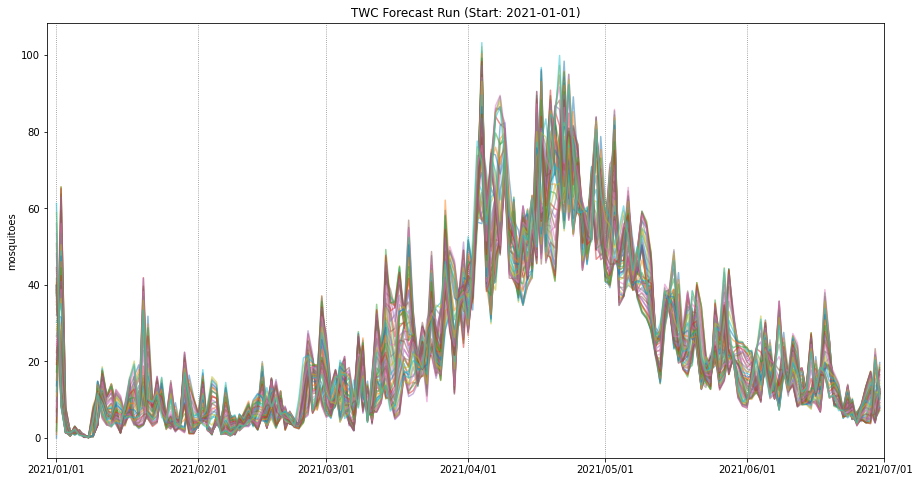

In [355]:
formatter = mdates.DateFormatter("%Y/%m/%d")
locator = mdates.MonthLocator()

fig = plt.figure(1, figsize=(15,8))

ax = plt.gca()
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)

#ax.plot(plot_dates, values, linestyle=None, marker='+', ms=8, mew=2)
for ens in df_values_agg3['forecast'].unique()[0:ens_show]:
    df_plot = df_values_agg3[df_values_agg3['forecast']==ens]
    ax.plot(df_plot['datetime'].values, df_plot['mosquitoes'].values, linestyle=None, marker='None', ms=8, mew=2, alpha = 0.5)

ax.set_xlim(start_date+timedelta(days=int(-2)), start_date+timedelta(days=int(181)))
plt.grid(axis='x', ls=":", color='0.5')
plt.ylabel('mosquitoes')
plt.xlabel("")
plt.title(f"TWC Forecast Run (Start: {start_date.strftime('%Y-%m-%d')})")
#plt.savefig("mosquitoes_50_ens_Jan-June_2021.png")
plt.show()

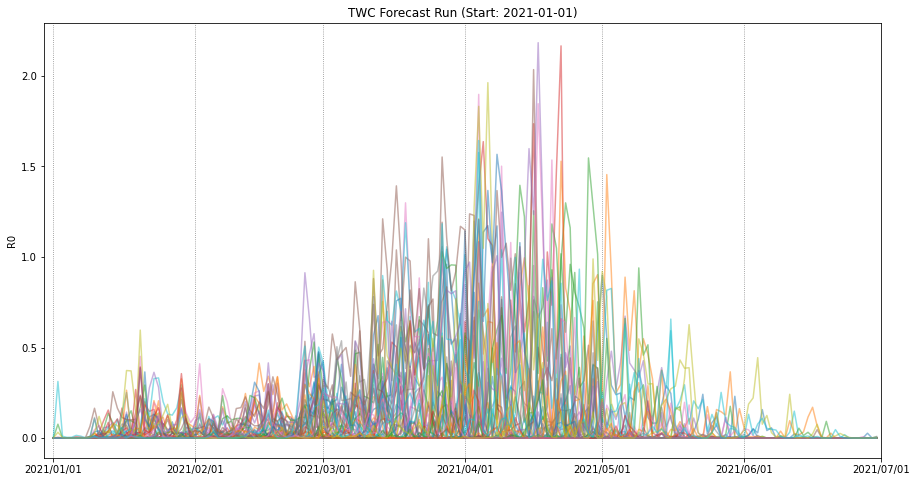

In [356]:
formatter = mdates.DateFormatter("%Y/%m/%d")
locator = mdates.MonthLocator()

fig = plt.figure(1, figsize=(15,8))

ax = plt.gca()
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)

#ax.plot(plot_dates, values, linestyle=None, marker='+', ms=8, mew=2)
for ens in df_values_agg3['forecast'].unique()[0:ens_show]:
    df_plot = df_values_agg3[df_values_agg3['forecast']==ens]
    ax.plot(df_plot['datetime'].values, df_plot['R0'].values, linestyle=None, marker='None', ms=8, mew=2, alpha = 0.5)

ax.set_xlim(start_date+timedelta(days=int(-2)), start_date+timedelta(days=int(181)))
plt.grid(axis='x', ls=":", color='0.5')
plt.ylabel('R0')
plt.xlabel("")
plt.title(f"TWC Forecast Run (Start: {start_date.strftime('%Y-%m-%d')})")
#plt.savefig("R0_50_ens_Jan-June_2021.png")
plt.show()

In [357]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
infostr = 'location: ' + str(query_lon) + ' E, ' + str(query_lat) + ' N'
print('Analysis for ' + infostr)

fig = make_subplots(rows=4, cols=1, shared_xaxes=True, \
                   subplot_titles = ['Rainfall', "Temperature", \
                                     "Model Mosquitoes", "Model R0"],
                   vertical_spacing = 0.05)
times = df_values_agg3['datetime']
fig.add_trace(
    go.Scatter(x=times, y=df_values_agg3['precip'], showlegend=False, mode='markers'), 
    row=1, col=1) 
fig.add_trace(
    go.Scatter(x=times, y=df_values_agg3['temp'], showlegend=False, mode='markers'), 
    row=2, col=1)
fig.add_trace(
    go.Scatter(x=times, y=df_values_agg3['mosquitoes'], showlegend=False, mode='markers'), 
    row=3, col=1)
fig.add_trace(
    go.Scatter(x=times, y=df_values_agg3['R0'], showlegend=False, mode='markers'), 
    row=4, col=1) 
fig.update_layout(
    autosize=False,
    width=800,
    height=900)
fig.update_yaxes(title_text="Rainfall [mm]", row=1, col=1)
fig.update_yaxes(title_text="Temperature [degC]", row=2, col=1)
fig.update_yaxes(title_text="Mosquito population size", row=3, col=1)
fig.update_yaxes(title_text="R0", row=4, col=1)
fig.for_each_yaxis(lambda axis: axis.title.update(font=dict(size=12)))

fig.show()


Analysis for location: [36.817222] E, [-1.286389] N


## Climate driver sensitivities 

In [358]:
print('Analysis for ' + infostr)
fig = make_subplots(rows=2, cols=2, shared_xaxes=False, \
                   subplot_titles = ['Rainfall and Mosquitoes',  \
                                     "Temperature and survival",\
                                     "Rainfall and R0",\
                                     "Temperature and R0"],
                   vertical_spacing = 0.1)

fig.add_trace(
    go.Scatter(x=df_values_agg3['precip'], y=df_values_agg3['mosquitoes'], showlegend=False, mode="markers"), 
    row=1, col=1) 
fig.add_trace(
    go.Scatter(x=df_values_agg3['temp'], y=df_values_agg3['P'], showlegend=False, mode="markers"), 
    row=1, col=2)
fig.add_trace(
    go.Scatter(x=df_values_agg3['precip'], y=df_values_agg3['R0'], showlegend=False, mode="markers"), 
    row=2, col=1)
fig.add_trace(
    go.Scatter(x=df_values_agg3['temp'], y=df_values_agg3['R0'], showlegend=False, mode="markers"), 
    row=2, col=2) 
fig.update_layout(
    autosize=False,
    width=800,
    height=800)
fig.for_each_yaxis(lambda axis: axis.title.update(font=dict(size=12)))

fig.show()

Analysis for location: [36.817222] E, [-1.286389] N


In [359]:
df_values_stats = df_values_agg3.groupby(['datetime'])

agg_list=['Precip_layer', "Temp_layer", 'precip', 'temp', 
          'P', 'gono_len', 'sporo_len', 'mosquitoes', 'R0']

df_values_stats=df_values_stats[agg_list].agg(['mean', 'std'])

df_values_stats.columns = ['_'.join(col_name).rstrip('_') for col_name in df_values_stats.columns.to_flat_index()]

df_values_stats
df_values_stats=df_values_stats.reset_index(drop=False)

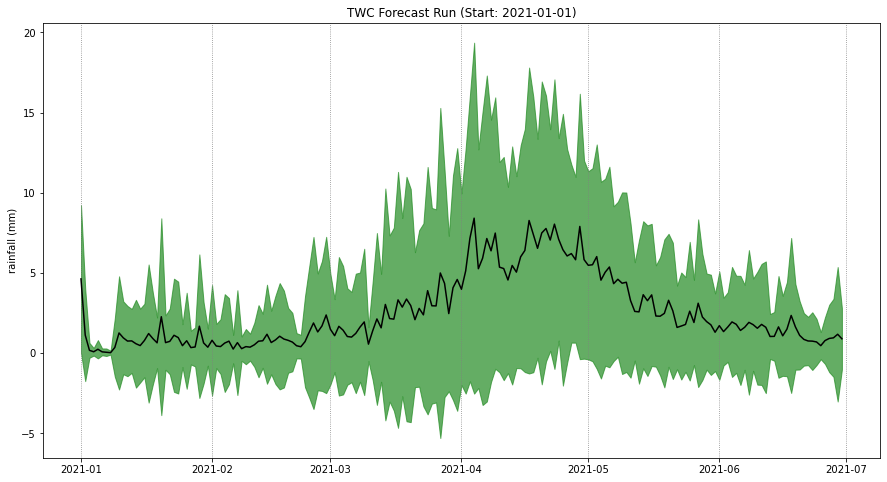

In [360]:
from matplotlib import pyplot as plt
import numpy as np

plt.figure(1, figsize=(15,8))

y = df_values_stats['precip_mean']
x = df_values_stats['datetime']
ypos=df_values_stats['precip_mean']+df_values_stats['precip_std']
yneg=df_values_stats['precip_mean']-df_values_stats['precip_std']

plt.plot(x, y, 'k-')
plt.fill_between(x, yneg, ypos, alpha = 0.7, color ='forestgreen')

ax.set_xlim(start_date+timedelta(days=int(-2)), start_date+timedelta(days=int(181)))
plt.grid(axis='x', ls=":", color='0.5')
plt.ylabel('rainfall (mm)')
plt.xlabel("")
plt.title(f"TWC Forecast Run (Start: {start_date.strftime('%Y-%m-%d')})")
#plt.savefig("precip_50_ens_Jan-June_2021.png")
plt.show()

In [361]:
df_values_stats.head()

datetime  Precip_layer_mean  Precip_layer_std  Temp_layer_mean  \
0 2021-01-01              50686               0.0            50685   
1 2021-01-02              50686               0.0            50685   
2 2021-01-03              50686               0.0            50685   
3 2021-01-04              50686               0.0            50685   
4 2021-01-05              50686               0.0            50685   

   Temp_layer_std  precip_mean  precip_std  temp_mean  temp_std    P_mean  \
0             0.0     4.629094    4.597076  16.878110  0.849775  0.904493   
1             0.0     1.128110    2.871892  18.064783  0.950783  0.901943   
2             0.0     0.175168    0.463113  17.984660  0.898410  0.902389   
3             0.0     0.085164    0.238152  17.984233  0.949595  0.902242   
4             0.0     0.243171    0.569702  17.986328  0.886830  0.902416   

      P_std  gono_len_mean  gono_len_std  sporo_len_mean  sporo_len_std  \
0  0.001775       5.755874      0.569458     1040.713543     501.918774   
1  0.004838       5.125159      0.427526      848.890686    1020.231081   
2  0.003842       5.158662      0.416899      662.190476     430.073750   
3  0.004000       5.165051      0.456984      982.614182    2059.532515   
4  0.003437       5.158392      0.428291      673.961986     468.619352   

   mosquitoes_mean  mosquitoes_std       R0_mean        R0_std  
0        30.577362       15.991572  4.080047e-09  2.885029e-08  
1        28.534457       19.604961  8.534035e-03  4.537524e-02  
2         3.503778        2.213207  3.026408e-04  1.422883e-03  
3         1.081466        0.437886  1.265039e-04  5.579539e-04  
4         2.149594        0.740210  1.374327e-04  6.488978e-04

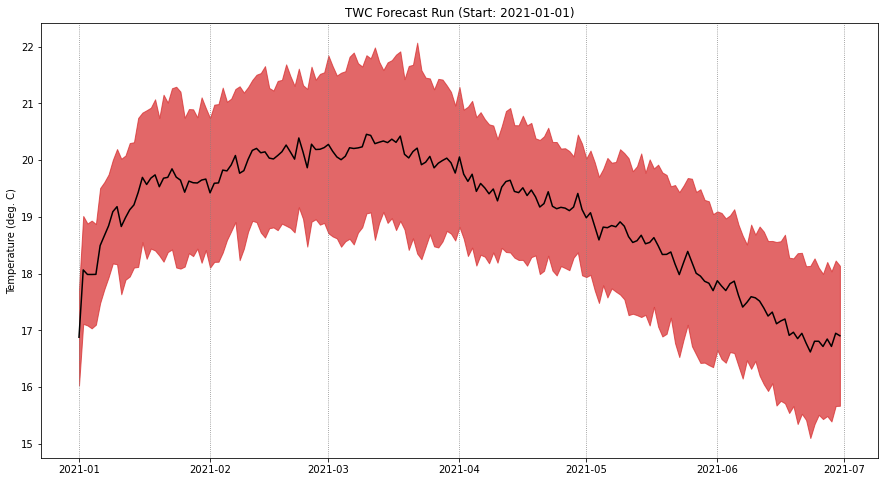

In [362]:
from matplotlib import pyplot as plt
import numpy as np

plt.figure(1, figsize=(15,8))

y = df_values_stats['temp_mean']
x = df_values_stats['datetime']
ypos=df_values_stats['temp_mean']+df_values_stats['temp_std']
yneg=df_values_stats['temp_mean']-df_values_stats['temp_std']

plt.plot(x, y, 'k-')
plt.fill_between(x, yneg, ypos, alpha = 0.7, color ='tab:red')

ax.set_xlim(start_date+timedelta(days=int(-2)), start_date+timedelta(days=int(181)))
plt.grid(axis='x', ls=":", color='0.5')
plt.ylabel('Temperature (deg. C)')
plt.xlabel("")
plt.title(f"TWC Forecast Run (Start: {start_date.strftime('%Y-%m-%d')})")
#plt.savefig("temp_50_ens_mean_Jan-June_2021.png")
plt.show()

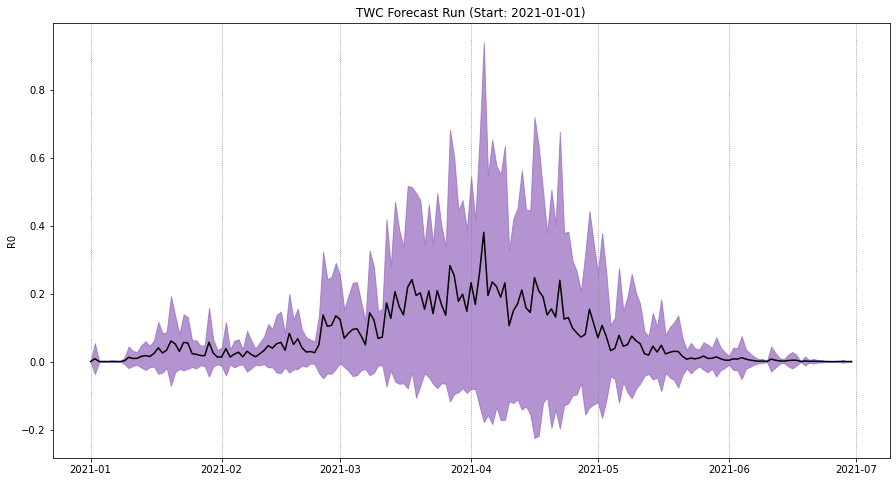

In [363]:
from matplotlib import pyplot as plt
import numpy as np

plt.figure(1, figsize=(15,8))

y = df_values_stats['R0_mean']
x = df_values_stats['datetime']
ypos=df_values_stats['R0_mean']+df_values_stats['R0_std']
yneg=df_values_stats['R0_mean']-df_values_stats['R0_std']

plt.plot(x, y, 'k-')
plt.fill_between(x, yneg, ypos, alpha = 0.7, color ='tab:purple')

ax.set_xlim(start_date+timedelta(days=int(-2)), start_date+timedelta(days=int(181)))
plt.grid(axis='x', ls=":", color='0.5')
plt.ylabel('R0')
plt.xlabel("")
plt.title(f"TWC Forecast Run (Start: {start_date.strftime('%Y-%m-%d')})")
#plt.savefig("R0_50_ens_mean_Jan-June_2021.png")
plt.show()

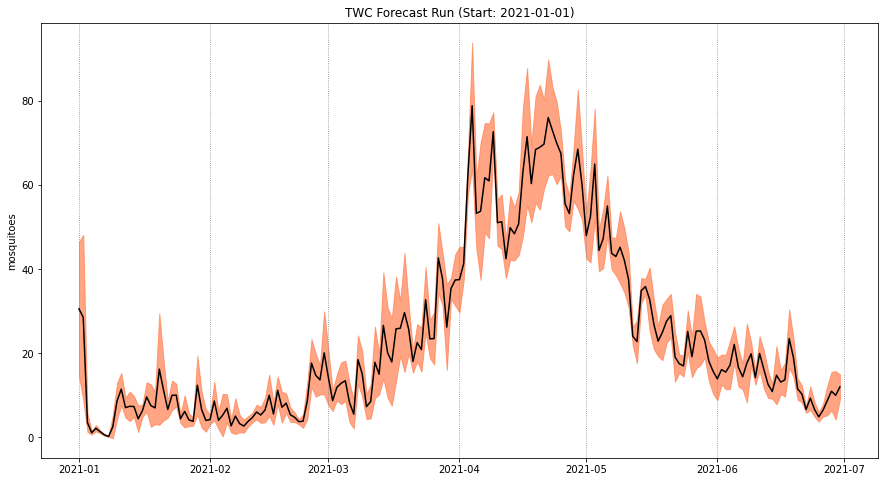

In [364]:
from matplotlib import pyplot as plt
import numpy as np

plt.figure(1, figsize=(15,8))

y = df_values_stats['mosquitoes_mean']
x = df_values_stats['datetime']
ypos=df_values_stats['mosquitoes_mean']+df_values_stats['mosquitoes_std']
yneg=df_values_stats['mosquitoes_mean']-df_values_stats['mosquitoes_std']

plt.plot(x, y, 'k-')
plt.fill_between(x, yneg, ypos, alpha = 0.7, color ='coral')

ax.set_xlim(start_date+timedelta(days=int(-2)), start_date+timedelta(days=int(181)))
plt.grid(axis='x', ls=":", color='0.5')
plt.ylabel('mosquitoes')
plt.xlabel("")
plt.title(f"TWC Forecast Run (Start: {start_date.strftime('%Y-%m-%d')})")
#plt.savefig("mosquitoes_50_ens_mean_Jan-June_2021.png")
plt.show()

In [365]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(x=df_month['month'], y=df_month['temperature'], name = 'ERA5 climatology', showlegend=True)) 
fig.update_layout(
    autosize=False,
    width=800,
    height=500)

fig.add_trace(
    go.Box(x=df_values_agg['month'], y=df_values_agg['temp'], name = 'Seasonal forecast', showlegend=True)) 

fig.update_yaxes(title_text="Monthly mean temperature [deg. C]")
fig.for_each_yaxis(lambda axis: axis.title.update(font=dict(size=12)))
fig.show()

In [366]:
df_values_stats['month'] = df_values_stats['datetime'].dt.month
df_values_stats['day'] = df_values_stats['datetime'].dt.day
df_values_stats['year'] = df_values_stats['datetime'].dt.year
df_values_stats

datetime  Precip_layer_mean  Precip_layer_std  Temp_layer_mean  \
0   2021-01-01              50686               0.0            50685   
1   2021-01-02              50686               0.0            50685   
2   2021-01-03              50686               0.0            50685   
3   2021-01-04              50686               0.0            50685   
4   2021-01-05              50686               0.0            50685   
..         ...                ...               ...              ...   
176 2021-06-26              50686               0.0            50685   
177 2021-06-27              50686               0.0            50685   
178 2021-06-28              50686               0.0            50685   
179 2021-06-29              50686               0.0            50685   
180 2021-06-30              50686               0.0            50685   

     Temp_layer_std  precip_mean  precip_std  temp_mean  temp_std    P_mean  \
0               0.0     4.629094    4.597076  16.878110  0.849775  0.904493   
1               0.0     1.128110    2.871892  18.064783  0.950783  0.901943   
2               0.0     0.175168    0.463113  17.984660  0.898410  0.902389   
3               0.0     0.085164    0.238152  17.984233  0.949595  0.902242   
4               0.0     0.243171    0.569702  17.986328  0.886830  0.902416   
..              ...          ...         ...        ...       ...       ...   
176             0.0     0.782040    1.453823  16.715240  1.280010  0.903015   
177             0.0     0.916565    2.100442  16.846715  1.358190  0.902731   
178             0.0     0.954044    2.429731  16.716108  1.322600  0.902842   
179             0.0     1.177580    4.191870  16.948250  1.282013  0.903039   
180             0.0     0.894001    1.906054  16.904081  1.234146  0.903235   

     ...  gono_len_std  sporo_len_mean  sporo_len_std  mosquitoes_mean  \
0    ...      0.569458     1040.713543     501.918774        30.577362   
1    ...      0.427526      848.890686    1020.231081        28.534457   
2    ...      0.416899      662.190476     430.073750         3.503778   
3    ...      0.456984      982.614182    2059.532515         1.081466   
4    ...      0.428291      673.961986     468.619352         2.149594   
..   ...           ...             ...            ...              ...   
176  ...      0.918323      867.807902     289.159205         6.441852   
177  ...      0.863814      902.009184     495.636518         8.688796   
178  ...      0.857225      851.868645     307.975292        10.970601   
179  ...      0.793454      820.002967     337.776809         9.994829   
180  ...      0.761600      899.695578     347.829645        11.992739   

     mosquitoes_std       R0_mean        R0_std  month  day  year  
0         15.991572  4.080047e-09  2.885029e-08      1    1  2021  
1         19.604961  8.534035e-03  4.537524e-02      1    2  2021  
2          2.213207  3.026408e-04  1.422883e-03      1    3  2021  
3          0.437886  1.265039e-04  5.579539e-04      1    4  2021  
4          0.740210  1.374327e-04  6.488978e-04      1    5  2021  
..              ...           ...           ...    ...  ...   ...  
176        1.485025  3.145874e-06  2.222080e-05      6   26  2021  
177        3.468116  1.558483e-04  1.037564e-03      6   27  2021  
178        4.573557  5.336449e-04  3.756011e-03      6   28  2021  
179        5.756122  5.599420e-05  2.422003e-04      6   29  2021  
180        2.964628  2.877209e-04  1.404875e-03      6   30  2021  

[181 rows x 22 columns]

In [367]:
df_all_vars = df_values_stats[['Precip_layer_mean', 'Temp_layer_mean',"month", "precip_mean", 'temp_mean', 'mosquitoes_mean','R0_mean' ]].groupby("month", as_index=False).aggregate("mean")

In [368]:
df_all_vars.head()

month  Precip_layer_mean  Temp_layer_mean  precip_mean  temp_mean  \
0      1              50686            50685     0.823791  19.132928   
1      2              50686            50685     0.831844  20.017024   
2      3              50686            50685     2.437398  20.151392   
3      4              50686            50685     6.430507  19.420512   
4      5              50686            50685     3.281394  18.468440   

   mosquitoes_mean   R0_mean  
0         7.835593  0.020831  
1         7.267627  0.047762  
2        20.951217  0.152939  
3        60.190994  0.173982  
4        32.627604  0.034525

In [369]:
df.tail()

rain_layer  day  month  year  longitude  latitude  rainfall  temp_layer  \
7301       49459   31     12  2016  36.817222 -1.286389  0.776760       49423   
7302       49459   31     12  2017  36.817222 -1.286389  0.104824       49423   
7303       49459   31     12  2018  36.817222 -1.286389  1.601968       49423   
7304       49459   31     12  2019  36.817222 -1.286389  0.954790       49423   
7305       49459   31     12  2020  36.817222 -1.286389  6.242887       49423   

      temperature         P  gono_len   sporo_len  mosquitoes        R0  
7301    19.823068  0.891719  4.418624   60.886375   15.900196  0.019045  
7302    21.646763  0.869193  3.925650   30.437954   15.048206  0.280774  
7303    19.502857  0.894576  4.522851   73.859312   13.525397  0.004555  
7304    19.614375  0.893618  4.485839   68.757268   12.664042  0.007043  
7305    18.854001  0.899359  4.754820  129.976373   11.933293  0.000015

In [370]:
df_all_vars_past = df[['rain_layer', 'temp_layer',"month", "rainfall", 'temperature', 'mosquitoes','R0' ]].groupby("month", as_index=False).aggregate("mean")
df_all_vars_past.head()

month  rain_layer  temp_layer  rainfall  temperature  mosquitoes        R0
0      1       49459       49423  1.147513    20.433954   16.734316  0.112935
1      2       49459       49423  1.035363    21.195888    8.881905  0.119216
2      3       49459       49423  2.367623    21.373573   12.403821  0.196931
3      4       49459       49423  4.562452    20.396425   25.268713  0.177567
4      5       49459       49423  2.939761    19.477302   35.699317  0.060391

In [375]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(x=df_all_vars_past['month'], y=df_all_vars_past['R0'], name = 'ERA5 climatology', showlegend=True)) 
fig.update_layout(
    autosize=False,
    width=800,
    height=500)

fig.add_trace(
    go.Box(x=df_values_stats['month'], y=df_values_stats['R0_mean'], name = 'Seasonal forecast', showlegend=True)) 

fig.update_yaxes(title_text="Monthly R0 average")
fig.for_each_yaxis(lambda axis: axis.title.update(font=dict(size=12)))
fig.show()

In [377]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(x=df_all_vars_past['month'], y=df_all_vars_past['mosquitoes'], name = 'ERA5 climatology', showlegend=True)) 
fig.update_layout(
    autosize=False,
    width=800,
    height=500)

fig.add_trace(
    go.Box(x=df_values_stats['month'], y=df_values_stats['mosquitoes_mean'], name = 'Seasonal forecast', showlegend=True)) 

fig.update_yaxes(title_text="Monthly mosquitoe average")
fig.for_each_yaxis(lambda axis: axis.title.update(font=dict(size=12)))
fig.show()